# Finding a Maximum Independent Set using Rydberg Atom Arrays

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from pulser import Pulse, Sequence, Register
from pulser.simulation import Simulation, SimConfig
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform, ConstantWaveform

from scipy.optimize import minimize
import skopt

In [14]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## 1. Introduction 

Given a Graph $G$ with vertices $V$ and edges $E$, an **Independent Set** is a subset of vertices such that no pair is connected by an edge. 
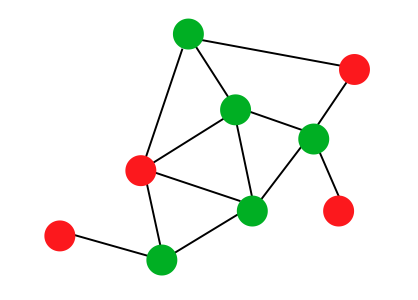

We consider the computational task of finding the **largest** of such independent sets: the **Maximal Independent Set** (MIS) problem. The solution of this problem can be expressed as the ground state of the following Hamiltonian:

$$
\mathcal{H}_{\text{MIS}} = - \sum_{i \in V} \hbar\Delta n_i + \sum_{(i,j)\in E} U_{ij} n_i n_j \qquad U_{ij} , \Delta > 0
$$

where $n_i = |1\rangle \langle 1|_i$. When $U > \Delta > 0$, this Hamiltonian favors spins being in the excited state, but if any two happen to be connected by an edge, the state gets heavily penalized.

This Hamiltonian can be natively realized on a neutral atoms processor, by restricting to edges below a certain threshold length, $r_B$ (This is called the *Unitary Disk* version of the MIS problem, UD-MIS). We map a  ground state and a Rydberg state of each atom to a two-level system, where $|1 \rangle = |r \rangle$ is a Rydberg state and $|0 \rangle = |g \rangle$ is a ground state. Placing $N$ atoms at positions $\textbf{r}_j$ in a 2D plane, and coupling the ground state $|0\rangle$ to the Rydberg state $|1\rangle$ with a laser system enables the realization of the Hamiltonian :

$$
H_{\text{Ryd}}= \sum_{i=1}^N \frac {\hbar \Omega} 2 \sigma_i^x - \sum_{i=1}^N \frac {\hbar\Delta} 2  \sigma_i^z+\sum_{j<i}\frac{C_6}{|\textbf{r}_i-\textbf{r}_j|^{6}} n_i n_j.
$$

Here, $\Omega$ and $\Delta$ are respectively the Rabi frequency and detuning of the laser system. The first two terms of the equation govern the transition between states $|0\rangle$ and $|1 \rangle$ induced by the laser, while the third term represents the repulsive Van der Waals interaction between atoms in the $|0\rangle$ state, which decays as $|\textbf{r}_i-\textbf{r}_j|^{-6}$ ($C_6$ is a constant related to the specific Rydberg level of the atoms).

### From a graph to an atomic register

We now illustrate how one can use Pulser and a neutral-atom device to find the MIS of a UD-graph. 

A link in the graph will correspond to two atoms that are within the Rydberg Blockade Radius, $r_B$ of each other. This quantity directly linked to the Rabi frequency $\Omega$ and can obtained using `Chadoq2.rydberg_blockade_radius()`. 

We first create an atomic register with 5 atoms. We draw our register with half-radius circles around the atoms to highlight the crossing of each one's blockade radius (thus forming a linked graph of interacting qubits). $\Omega$ is fixed to a frequency of 1 rad/µs:

In [15]:
T = 1000    # duration
U = 2 * np.pi * 2.

Omega_max = 1.2 * U 
DELTA = U

m = 3

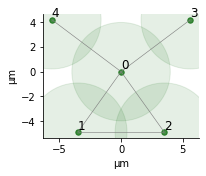

In [16]:

pos = np.array([[0, 0], [-5, -7], [5,-7], [8,6], [-8,6]]) * 0.7

omega_effective = np.sqrt(Omega_max**2 + DELTA**2)

reg = Register.from_coordinates(pos, center=False)

reg.draw(blockade_radius=Chadoq2.rydberg_blockade_radius(omega_effective),
         draw_graph=True,
         draw_half_radius=True)

This graph has two maximal independent sets: $(1,3,4)$ and $(2,3,4)$, respectively `01011` and `00111` in binary labels (also called "bitstrings"). 

In [17]:
def create_interp_pulse(amp_params):
    return Pulse(
        InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]), 
        ConstantWaveform(T, DELTA),
        0,
    )

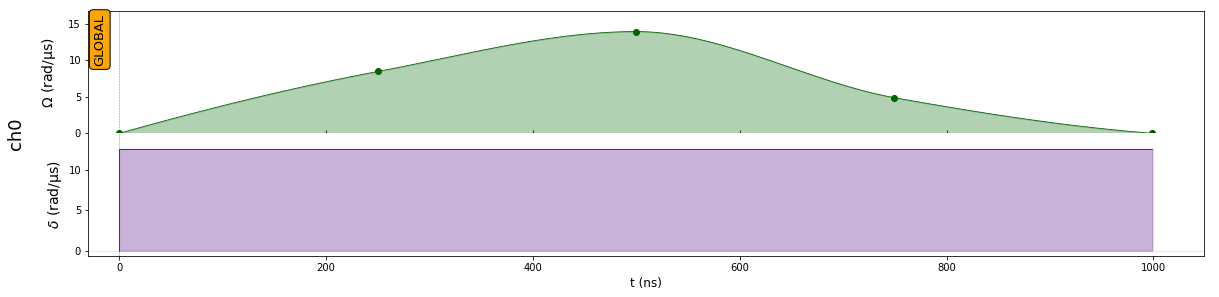

In [19]:
# Random instance of the parameter space
amp_params = np.random.uniform(0,Omega_max,m)

seq = Sequence(reg, Chadoq2)
seq.declare_channel('ch0', 'rydberg_global')
seq.add(create_interp_pulse(amp_params),'ch0')
seq.draw()

In [24]:
def quantum_loop(param, register, noise=False, show_seq=False):
    seq = Sequence(register, Chadoq2)
    seq.declare_channel('ch0','rydberg_global')
    
    seq.add(create_interp_pulse(param), 'ch0')
    
    seq.measure('ground-rydberg')
    simul = Simulation(seq, sampling_rate=.008)
    if noise:
        sim_config = SimConfig(noise=('SPAM', 'doppler', 'amplitude'),
                             eta=0.001, epsilon=0.01, epsilon_prime=0.01, temperature=10,
                             runs=100, samples_per_run=10)
    
        simul.add_config(sim_config)
    if show_seq: simul.draw()
    results = simul.run()
    count_dict = results.sample_final_state() #sample from the state vector 
    return count_dict 

We can then plot the distribution of the samples, to see the most frequent bitstrings sampled.

In [25]:
def plot_distribution(C):
    C = dict(sorted(C.items(), key=lambda item: item[1]))
    indexes = ['01011', '00111']  # MIS indexes
    color_dict = {key:'r' if key in indexes else 'lightgray' for key in C}
    plt.figure(figsize=(8,2))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.8, color = color_dict.values())
    plt.xticks(rotation='vertical')
    plt.show()

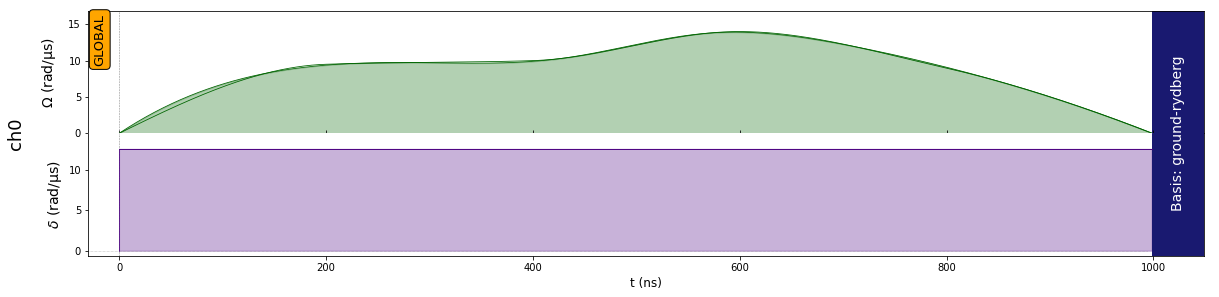

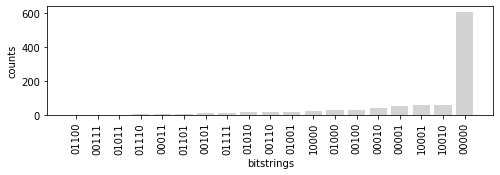

In [41]:
example_params = [9.5, 10, 14, 9]
res_dict = quantum_loop(example_params, reg, noise=False, show_seq=True)
plot_distribution(res_dict)

The bitstrings `01011` and `00111` (in red) correspond to the two MIS of the graph. The goal of QAOA is to choreograph interferences between the basis states, in order to maximize the frequency of the MIS states. 

## 3. Optimization 

We estimate the cost of a sampled state vector $|\psi(\bf t, \boldsymbol \tau)\rangle$ by making an average over the samples. This is done by taking the corresponding bitstring ${\bf z}=(z_1, \ldots, z_N)$ and calculating

$$
C({\bf z}) = - \Delta \sum_i z_i + \sum_{i\geq j} U_{ij}z_iz_j ,
$$

Determining the cost of a given bitstring takes polynomial time. The average estimate is then used in the classical loop to optimize the variational parameters $\tau$ and $t$.

In [42]:
def bitstring_cost(bitstring, register):
    z = np.array(list(bitstring), dtype=int)
    cost = 0
    coord_list = list(register.qubits.values())
    for i, x1 in enumerate(coord_list):
        for j, x2 in enumerate(coord_list):
            if j>i:
                cost += z[i]*z[j] * Chadoq2.rabi_from_blockade(np.linalg.norm(x1-x2))
            
    return cost - DELTA*np.sum(z)*2 # Factor of two coming from H_ryd definition

def get_cost(counter, register):
    cost = sum(counter[key] * bitstring_cost(key,register) for key in counter) 
    return cost / sum(counter.values()) # Divide by total samples

In [43]:
n_qubits = len(reg.qubits)
binary_numbers = [np.binary_repr(i, n_qubits) for i in range(2**n_qubits)]
cost_dict = {k: bitstring_cost(k, reg) for k in binary_numbers}
sorted(cost_dict.items(), key=lambda x: x[1])[:6]

[('00111', -64.2093307565588),
 ('01011', -64.2093307565588),
 ('00101', -49.16295908123742),
 ('01010', -49.16295908123742),
 ('00011', -47.727912574591265),
 ('00110', -42.716682786885144)]

In [44]:
get_cost(res_dict, reg)

-9.575307132866516

In [45]:
def func(param, register, noise):
    C = quantum_loop(param, register, noise)
    cost = get_cost(C, register)
    #print(cost, np.round(param,3))
    tot_cost.append(cost)
    return cost

We will use a classical optimizer `scipy.optimize.minimize` in order to find the best variational parameters. This function takes as arguments `func`, and an initial `x0` point for the simplex in Nelder-Mead minimization. To contrast, we'll also consider a global search using a multivariate gaussian model, `GP_minimize`:

In [47]:
def GP_minimize(m, calls, register, noise):
    dimensions = skopt.Space([(0.0, Omega_max)] * m )
    res = skopt.gp_minimize(
            lambda pars: func(pars, register, noise),
            dimensions,
            n_calls=calls,
            verbose=False,
            n_initial_points=10
            )
    return res

As the number of layers grows, the variational state will tend to approximate better the ground state of $\mathcal H_{\text{MIS}}$. The optimization of the parameters, however, becomes more complex and there are many approaches available to attack this step. Here we try a global search:

Parameters = 2
Attempt # 1
Final energy: -15.323745709930574
Final parameters: [15.079644737231007, 15.079644737231007]


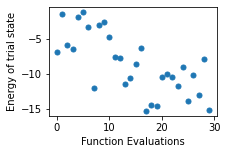

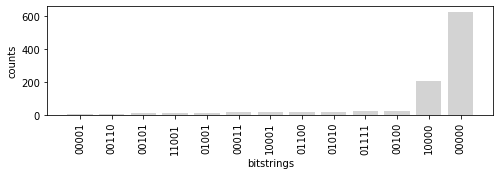

Parameters = 2
Attempt # 2
Final energy: -14.445945525718994
Final parameters: [15.079644737231007, 0.0]


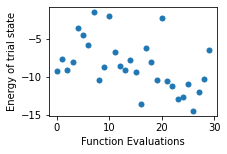

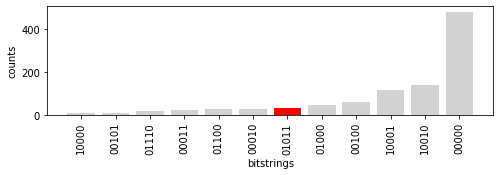

Parameters = 3
Attempt # 1
Final energy: -46.928964481139495
Final parameters: [10.637722982520696, 0.0, 8.53438162840089]


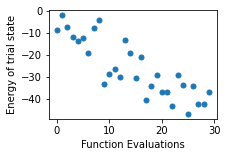

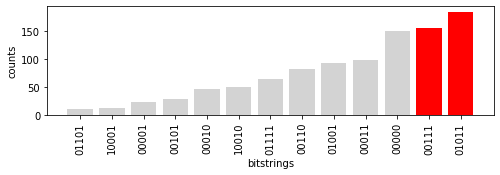

Parameters = 3
Attempt # 2
Final energy: -38.59774575556999
Final parameters: [9.442851379135568, 0.0, 8.514686323789268]


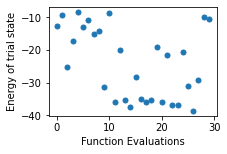

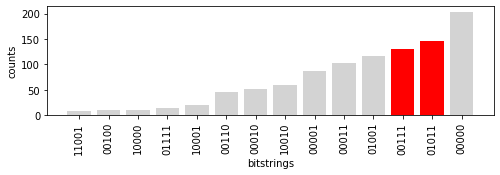

Parameters = 4
Attempt # 1
Final energy: -38.92421351523064
Final parameters: [12.756183467845496, 0.0, 1.8640181096150281, 7.108988021495419]


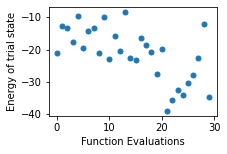

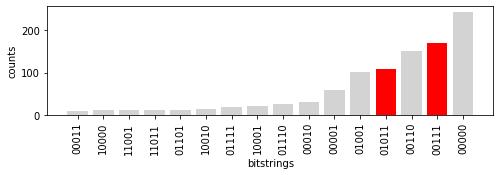

Parameters = 4
Attempt # 2
Final energy: -33.758899434077264
Final parameters: [15.079644737231007, 0.0, 0.0, 8.89816625211639]


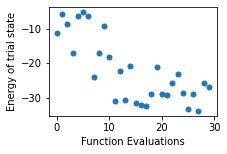

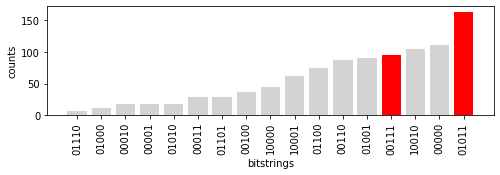

In [94]:
for m in [2,3,4]:
    for attempts in range(2):
        print(f'Parameters = {m}')
        print(f'Attempt # {attempts+1}')
        
        tot_cost = []
        
        # Optimize Parameters
        #initial_pars = np.array(4*np.random.rand(2*layers)) # For Nelder mead
        #res = minimize(func, x0=initial_pars, args=(reg,False), method='Nelder-Mead', options={'maxfev': 100})
        res = GP_minimize(m=m, calls=30, register=reg, noise=True)
        
        # Plot Energy of Function Evaluations:
        plt.figure(figsize=(3,2))
        plt.plot(tot_cost, 'o', markersize=5)
        #plt.ylim(0, max(tot_cost)+0.1)
        plt.ylabel("Energy of trial state")
        plt.xlabel("Function Evaluations")
        
        # Plot Sampling of Optimized State:
        count_dict = quantum_loop(res.x, register=reg, noise=True)
        print(f'Final energy: {res.fun}')
        print(f'Final parameters: {res.x}')
        plot_distribution(count_dict)

Notice that as the number of layers increases, the variational state becomes more expressive and for a given budget of function evaluations, we can find a stronger signal of the MIS. On the other hand, as the number of layers increases, the computational cost increases and the optimization itself can become more difficult.

Let us try now some randomly generated graphs:

In [95]:
def plot_MIS(bitstring, register):
    coords = np.array(list(register.qubits.values()))
    plt.scatter(coords[:,0], coords[:,1], color='green', s=200)
    
    excited = np.array([coord for i, coord in enumerate(coords) if bitstring[i]=='1'])
    if len(excited) > 0:
        plt.scatter(excited[:,0], excited[:,1], color='red', s=400)
    
def plot_counter(counter, register, element=-1):
    sorted_counter = sorted(counter.items(), key=lambda item: item[1]) 
    C = dict(sorted_counter)
    plt.figure(figsize=(8,2))
    plt.xlabel("bitstrings")
    plt.ylabel("counts")
    plt.bar(C.keys(), C.values(), width=0.85, color = 'gray')
    plt.xticks(rotation='vertical')
    plt.show()
    print(sorted_counter[element][0])
    plot_MIS(sorted_counter[element][0], register)

It may be that the given random assignment does not respect the restriction of the device in Pulser. For the moment we will just choose some functional seed and find the MIS of a 7-vertex graph:

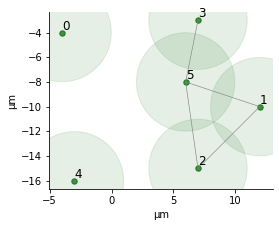

In [96]:
np.random.seed(1)
n_qubits = 6
good_coords = False
while good_coords == False:
    pos = np.random.randint(-18,18,(n_qubits,2))
    distances = np.array([np.linalg.norm(pos[i]-pos[j]) for i in range(n_qubits) for j in range(i+1,n_qubits)])
    good_coords = np.all(distances > 5) and np.all(distances < 18)
    
random_reg = Register.from_coordinates(pos, center=False)
omega_effective = np.sqrt(Omega_max**2 + DELTA**2)
random_reg.draw(blockade_radius=Chadoq2.rydberg_blockade_radius(omega_effective), draw_graph=True, draw_half_radius=True)

In [102]:
tot_cost = []
#initial_pars = np.array(2*np.random.rand(2*layers)) # For Nelder mead
#res = minimize(func, x0=initial_pars, args=random_reg, method='Nelder-Mead', options={'maxfev': 20})
res = GP_minimize(m=3, calls=80, register=random_reg, noise=True)

Final energy: -49.12862868749524
Final parameters: [10.878530799215312, 0.0, 9.940809847244651]


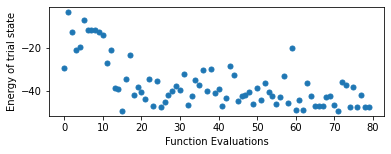

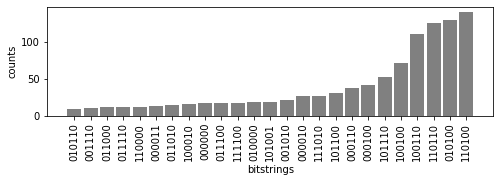

110110


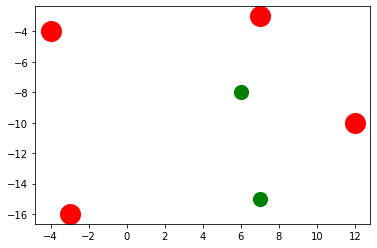

In [103]:
# Plot Energy of Function Evaluations:
plt.figure(figsize=(6,2))
plt.plot(tot_cost, 'o', markersize=5)
plt.ylabel("Energy of trial state")
plt.xlabel("Function Evaluations")

# Plot Sampling of Optimized State:
count_dict = quantum_loop(res.x, random_reg, noise=True)
print(f'Final energy: {res.fun}')
print(f'Final parameters: {res.x}')
plot_counter(count_dict, random_reg, element=-3)

Notice that in this case we don't calculate beforehand the set of MIS of the graph. For a very large instance what one usually does is verify that the produced solution is indeed an independent set (which we do here visually).